In [9]:
from urllib2 import Request, urlopen
from urlparse import urlparse, urlunparse
import requests, requests_cache
import pandas as pd
import json
from wordcloud import WordCloud
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from bs4 import BeautifulSoup
import re
from os import listdir
from os import chdir
from os.path import isfile, join
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
import string
from textblob import TextBlob
import pylab
from __future__ import division
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import itertools
from collections import Counter

We first want to read all of the text files we have from web scraping. 

In [2]:
def read_text(filename):
    """
    This function reads a txt file with filtered or unfiltered list of titles
    Input: A txt file
    Output: Filtered list of titles
    """
    
    title_names = []
    text_file = open(filename,"r")

    for line in text_file:
        line = line.strip()
        title_names.append(line)

    return title_names

Function that takes the list of lists of titles and returns the noun polarity and subjectivity. 

In [20]:
def noun_polarity(total_list):
    """
    This function takes in a list of titles
    and separates the titles in noun phrases
    and returns the polarity and subjectivity
    Input: List of Article Titles
    Output: Subjectivity and Polarity of Noun Phrases
    """
    
    noun_phrases = []
    for title in total_list:
        blob = TextBlob(title)
        noun_phrases.extend(blob.noun_phrases)
    
    noun_polarity = []
    noun_subjectivity = []
    for noun in noun_phrases:
        blob = TextBlob(noun)
        noun_polarity.append(blob.sentiment.polarity)
        noun_subjectivity.append(blob.sentiment.subjectivity)
    
    return noun_polarity, noun_subjectivity

Function that takes in the total polarity, list name, type of news, and length of list and returns the total polarity level.

In [27]:
def polarity_levels(total_pol, name, typenews, num):
    """
    This function takes in all the polarity and gets 
    the ratio of polarity based on the news outlet
    Input: Polarity, Name, Category, and number of articles
    Output: List consisting of the name, negative and positive
    polarity ratio, category
    """
    pos_pol = [i for i in total_pol if i > 0]
    pos_pol = str(len(pos_pol) / num)
    neg_pol = [i for i in total_pol if i < 0]
    neg_pol = str(len(neg_pol) / num)
    all_pol = [name, neg_pol, pos_pol, typenews]
    
    return all_pol

In [5]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

Takes in the article titles and returns the polarity of the titles (not just the nouns)

In [6]:
#see how pos/neg the titles are
def polar_subj(article_titles):
    """
    Takes each article title and determines the polarity & subjectivity 
    Input: list of article titles (list)
    Output: title_polarity (list), title_subj (list)
    """
    title_polarity = []
    title_subj = []
    for title in article_titles:
        blob = TextBlob(title)
        title_polarity.append(blob.sentiment.polarity)
        title_subj.append(blob.sentiment.subjectivity)
    return title_polarity, title_subj

In [7]:
huff = read_text("huffpost.txt")
abc = read_text("abc.txt")
economist = read_text("economist.txt")
fox = read_text("fox.txt")
npr = read_text("npr.txt")
nytimes = read_text("nytimes.txt")
washington = read_text("washington.txt")
wsj = read_text("wsj.txt")
breitbart = read_text("breitbart.txt")

In [21]:
huff_noun_pol, huff_noun_sub = noun_polarity(huff)
abc_noun_pol, abc_noun_sub = noun_polarity(abc)
economist_noun_pol, economist_noun_sub = noun_polarity(economist)
fox_noun_pol, fox_noun_sub = noun_polarity(fox)
npr_noun_pol, npr_noun_sub = noun_polarity(npr)
nytimes_noun_pol, nytimes_noun_sub = noun_polarity(nytimes)
washington_noun_pol, washington_noun_sub = noun_polarity(washington)
wsj_noun_pol, wsj_noun_sub = noun_polarity(wsj)
breitbart_noun_pol, breitbart_noun_sub = noun_polarity(breitbart)

In [28]:
hp = polarity_levels(huff_noun_pol, "Huffington Post", "Liberal", len(huff))
ab = polarity_levels(abc_noun_pol, "ABC News", "Liberal", len(abc))
ec = polarity_levels(economist_noun_pol, "Economist", "Other", len(economist))
fo = polarity_levels(fox_noun_pol, "Fox", "Conservative", len(fox))
np = polarity_levels(npr_noun_pol, "NPR", "Other", len(npr))
ny = polarity_levels(nytimes_noun_pol, "NYTimes", "Liberal", len(nytimes))
wa = polarity_levels(washington_noun_pol, "Washington Post", "Liberal", len(washington))
ws = polarity_levels(wsj_noun_pol, "WSJ", "Other", len(wsj))
br = polarity_levels(breitbart_noun_pol, "Breitbart", "Conservative", len(breitbart))

In [29]:
df = pd.DataFrame([hp, ab, ec, fo, np, ny, wa, ws, br])
df.columns = ['News Outlet', 'Negative', 'Positive', 'Category']
df

,News Outlet,Negative,Positive,Category
0,Huffington Post,0.185628742515,0.173652694611,Liberal
1,ABC News,0.13698630137,0.123287671233,Liberal
2,Economist,0.027027027027,0.0810810810811,Other
3,Fox,0.0737179487179,0.0897435897436,Conservative
4,NPR,0.10514541387,0.136465324385,Other
5,NYTimes,0.04375,0.06875,Liberal
6,Washington Post,0.0774647887324,0.147887323944,Liberal
7,WSJ,0.123287671233,0.150684931507,Other
8,Breitbart,0.0727272727273,0.2,Conservative


The dataframe above has 4 columns. First column is the name of the newspaper, second is negative polarity, third is the positive polarity, and the fourth column is the type (liberal, conservative, or other).

In [30]:
df_conservative = df[df['Category'] == "Conservative"]
df_conservative

,News Outlet,Negative,Positive,Category
3,Fox,0.0737179487179,0.0897435897436,Conservative
8,Breitbart,0.0727272727273,0.2,Conservative


In [31]:
df_other = df[df['Category'] == "Other"]
df_other

,News Outlet,Negative,Positive,Category
2,Economist,0.027027027027,0.0810810810811,Other
4,NPR,0.10514541387,0.136465324385,Other
7,WSJ,0.123287671233,0.150684931507,Other


In [32]:
df_liberal = df[df['Category'] == "Liberal"]
df_liberal

,News Outlet,Negative,Positive,Category
0,Huffington Post,0.185628742515,0.173652694611,Liberal
1,ABC News,0.13698630137,0.123287671233,Liberal
5,NYTimes,0.04375,0.06875,Liberal
6,Washington Post,0.0774647887324,0.147887323944,Liberal


In [34]:
lib1 = sum(float(item) for item in df_liberal['Negative'])
con1 = sum(float(item) for item in df_conservative['Negative'])
oth1 = sum(float(item) for item in df_other['Negative'])
lib2 = sum(float(item) for item in df_liberal['Positive'])
con2 = sum(float(item) for item in df_conservative['Positive'])
oth2 = sum(float(item) for item in df_other['Positive'])
total_other = [oth1, oth2]
total_con = [con1, con2]
total_lib = [lib1, lib2]

In [35]:
import numpy as np
ind = np.arange(2)

<h3>The following graphs show the polarity levels of the NOUNS in the article titles</h3>

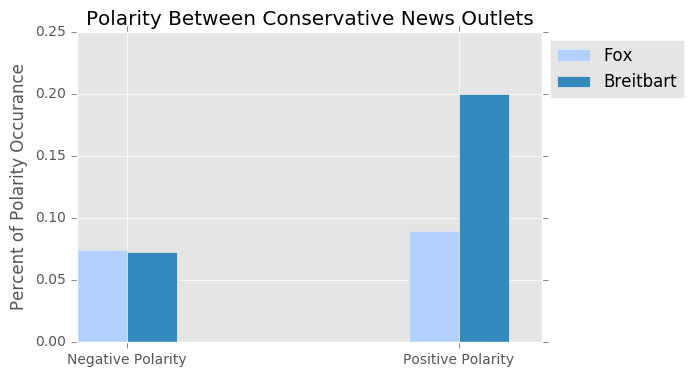

In [37]:
ind = np.arange(2)
width = 0.15
fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, df_conservative.iloc[0, 1:3].values, width, color='b')
rects1 = ax.bar(ind, df_conservative.iloc[0, 1:3].values, width, color='#b3d1ff')

rects2 = ax.bar(ind+width, df_conservative.iloc[1, 1:3].values, width)

ax.set_ylabel('Percent of Polarity Occurance')
ax.set_xticks(ind+width)
ax.set_title("Polarity Between Conservative News Outlets")
ax.set_xticklabels( ('Negative Polarity', 'Positive Polarity') )
ax.legend( (rects1[0], rects2[0]), ('Fox', 'Breitbart'), bbox_to_anchor=(1, 1), loc=2)
plt.show()

The graph above shows the polarity between the conservative news outlets. We see that Fox and Breitbart have about the same percent of negativity in their news relating to Trump. However, Breitbart is significantly more positive than Fox. This makes a lot of sense because Breitbart is known to be very pro Trump.

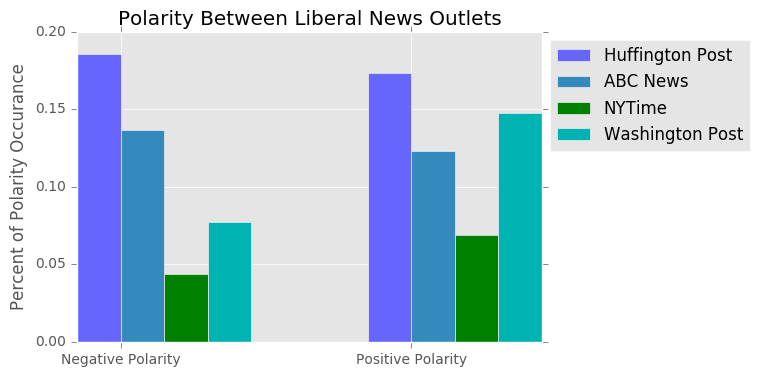

In [38]:
width = 0.15
fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, df_liberal.iloc[0, 1:3].values, width, color='#6666ff')


rects2 = ax.bar(ind+width, df_liberal.iloc[1, 1:3].values, width)
rects3 = ax.bar(ind+width+width, df_liberal.iloc[2, 1:3].values, width, color = 'g')

rects4 = ax.bar(ind+width+width+width, df_liberal.iloc[3, 1:3].values, width, color = '#00b3b3')

ax.set_ylabel('Percent of Polarity Occurance')
ax.set_xticks(ind+width)
ax.set_title("Polarity Between Liberal News Outlets")
ax.set_xticklabels( ('Negative Polarity',  'Positive Polarity') )
ax.legend( (rects1[0], rects2[0], rects3[0], rects4[0]), ('Huffington Post', 'ABC News', 'NYTime', 'Washington Post'), bbox_to_anchor=(1, 1), loc=2)
plt.show()

This graph (above)shows the polarity percentage difference between the liberal news outlets. We see that Huffington post is the highest with both positive and negative polarity. NYTimes had the lowest percent polarity for negative occurances and positive occurances. ABC news is similar to Huffington post in the way that it also has about equal percentage between positive and negative polarity. Washington Post is the only one of the 4 liberal news outlets that had more overall positive polarity than negative polarity.

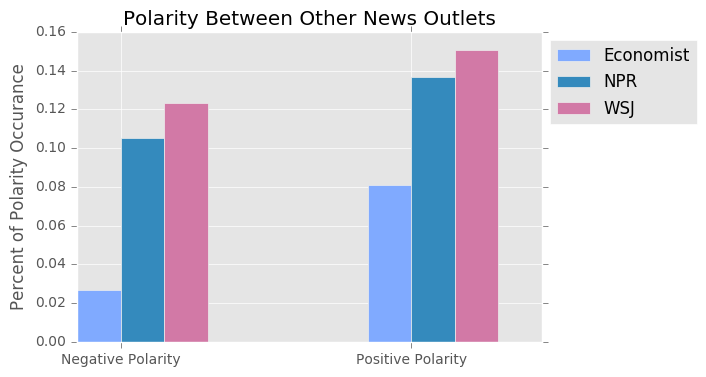

In [39]:
width = 0.15
fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, df_other.iloc[0, 1:3].values, width, color='#80aaff')

rects2 = ax.bar(ind+width, df_other.iloc[1, 1:3].values, width)
rects3 = ax.bar(ind+width+width, df_other.iloc[2, 1:3].values, width, color = '#d279a6')


ax.set_ylabel('Percent of Polarity Occurance')
ax.set_xticks(ind+width)
ax.set_title("Polarity Between Other News Outlets")
ax.set_xticklabels( ('Negative Polarity', 'Positive Polarity') )
ax.legend( (rects1[0], rects2[0], rects3[0]), ('Economist', 'NPR', 'WSJ'), bbox_to_anchor=(1, 1), loc=2)
plt.show()

Overall, the polarity between the other news outlets were more positive than negative. They were all relatively similar (between positive and negative) which can lead us to believe that the other news outlets are somewhat neutral in their reports. There aws however more positive nouns than negative nouns (polarity percentage) across all 3 news outlets.

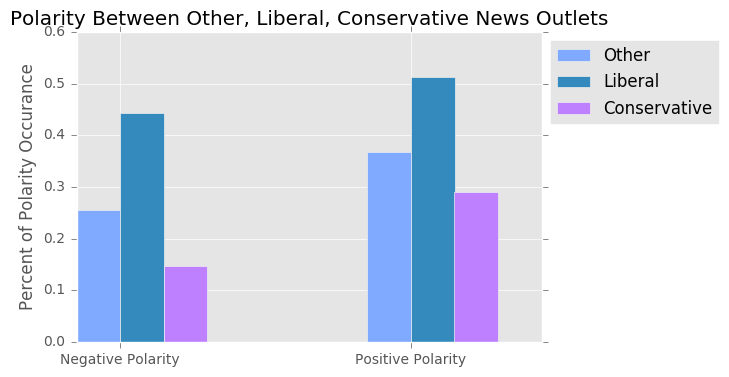

In [40]:
width = 0.15
fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, total_other, width, color='#80aaff')

rects2 = ax.bar(ind+width, total_lib, width)
rects3 = ax.bar(ind+width+width, total_con, width, color = '#bf80ff')


ax.set_ylabel('Percent of Polarity Occurance')
ax.set_xticks(ind+width)
ax.set_title("Polarity Between Other, Liberal, Conservative News Outlets")
ax.set_xticklabels( ('Negative Polarity', 'Positive Polarity') )
ax.legend( (rects1[0], rects2[0], rects3[0]), ('Other', 'Liberal', 'Conservative'), bbox_to_anchor=(1, 1), loc=2)
plt.show()

Overall, we see that all 3 types of news outlets had a higher positive polarity noun count than negative. 

<h3>Most Commonly Used Words in Articles Titles and News Outlets </h3>

In [41]:
#Puts all the titles together into a list according to category
total = huff + abc + economist + fox + npr + nytimes + washington + wsj + breitbart
conserv = fox + breitbart
liber = huff + abc + nytimes + washington
othernews = economist + npr + wsj

In [42]:
def token_word(all_titles):
    """
    This function takes in a list of titles 
    and removes stop words and Trump's administration names
    and removes punctuation
    Input: List
    Output: List of single words
    """
    tokentit = [re.sub("[^a-zA-Z]"," ",i) for i in all_titles]
    tokenword = [word_tokenize(w) for w in tokentit]
    merged = list(itertools.chain(*tokenword))
    words = [w for w in merged if not w in stopwords.words("english")]
    trumps_admin = ['whitehouse','Trump','conway','sessions','pence','president','tillerson', 'Spicer', 'devos','march', 'flynn','kushner','carson','department','preibus','bannon','spicer','miller', 'steve','Donald','jeff','sean', 'trump', 'President', 'donald', 'white', 'White', 'house', 'House', 'u']
    wording = [w for w in words if not w in trumps_admin]
    new_words = []
    total_titles = [line.translate(None, string.punctuation) for line in wording]
    token_word = [new_words.extend(word_tokenize(w)) for w in wording]
    filtered_words = [word for word in new_words if word.lower() not in stopwords.words('english')]
    
    return filtered_words

In [43]:
#Tokenize all news
combined_news = token_word(total)
conserv_news = token_word(conserv)
liber_news = token_word(liber)
other_news = token_word(othernews)
huff_tok = token_word(huff)
abc_tok = token_word(abc)
econ_tok = token_word(economist)
fox_tok = token_word(fox)
npr_tok = token_word(npr)
nyt_tok = token_word(nytimes)
wash_tok = token_word(washington)
bb_tok = token_word(breitbart)
wsj_tok = token_word(wsj)

In [50]:
#Count the top 20 most frequently used words and put in a dataframe
df_combined = pd.DataFrame(Counter(combined_news).most_common()[0:20])
df_c = pd.DataFrame(Counter(conserv_news).most_common()[0:20])
df_o = pd.DataFrame(Counter(other_news).most_common()[0:20])
df_l = pd.DataFrame(Counter(liber_news).most_common()[0:20])
df_huff = pd.DataFrame(Counter(huff_tok).most_common()[0:20])
df_abc = pd.DataFrame(Counter(abc_tok).most_common()[0:20])
df_econ = pd.DataFrame(Counter(econ_tok).most_common()[0:20])
df_fox = pd.DataFrame(Counter(fox_tok).most_common()[0:20])
df_npr = pd.DataFrame(Counter(npr_tok).most_common()[0:20])
df_nyt = pd.DataFrame(Counter(nyt_tok).most_common()[0:20])
df_wash = pd.DataFrame(Counter(wash_tok).most_common()[0:20])
df_bb = pd.DataFrame(Counter(bb_tok).most_common()[0:20])
df_wsj = pd.DataFrame(Counter(wsj_tok).most_common()[0:20])

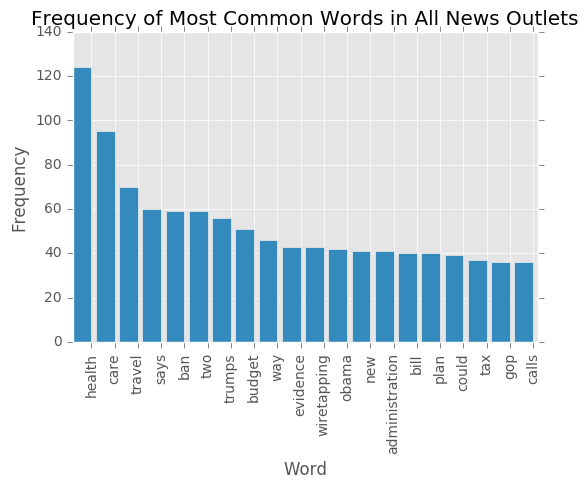

In [53]:
ind = np.arange(20)
width = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, df_combined.ix[:, 1].values, width)
ax.set_ylabel('Frequency')
ax.set_xlabel('Word')
ax.set_xticks(ind+width)
ax.set_title("Frequency of Most Common Words in All News Outlets")
ax.set_xticklabels(df_combined[0], rotation = 90)
plt.show()

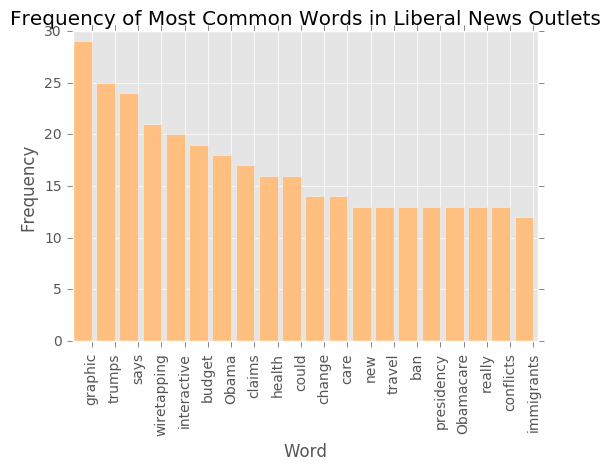

In [52]:
ind = np.arange(20)
width = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, df_l.ix[:, 1].values, width, color = "#ffbf80")
ax.set_ylabel('Frequency')
ax.set_xlabel('Word')
ax.set_xticks(ind+width)
ax.set_title("Frequency of Most Common Words in Liberal News Outlets")
ax.set_xticklabels(df_l[0], rotation = 90)
plt.show()

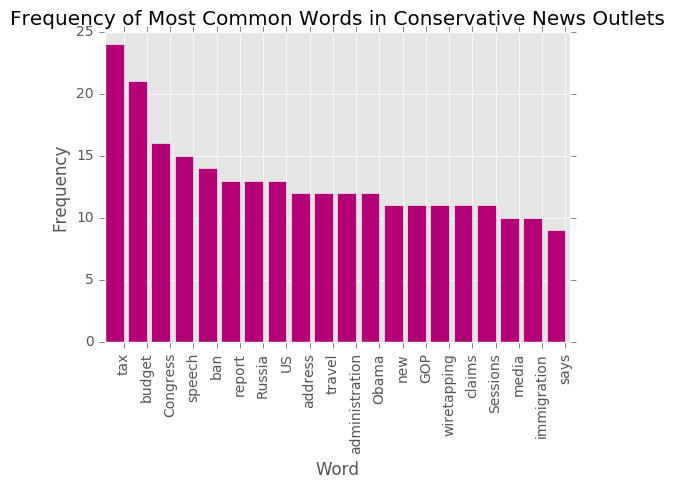

In [47]:
ind = np.arange(20)
width = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, df_c.ix[:, 1].values, width, color = "#b30077")
ax.set_ylabel('Frequency')
ax.set_xlabel('Word')
ax.set_xticks(ind+width)
ax.set_title("Frequency of Most Common Words in Conservative News Outlets")
ax.set_xticklabels(df_c[0], rotation = 90)
plt.show()

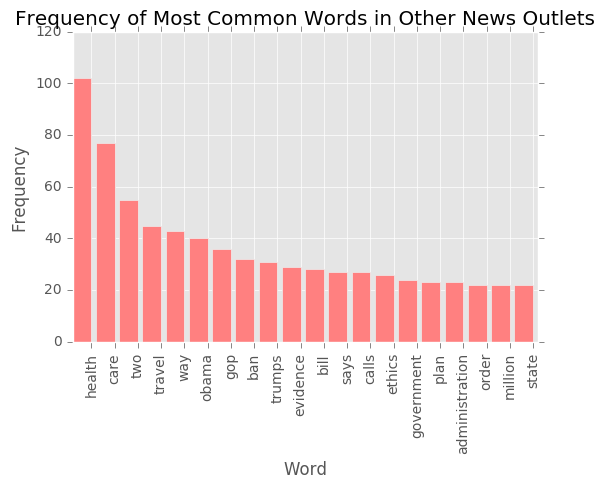

In [54]:
ind = np.arange(20)
width = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, df_o.ix[:, 1].values, width, color = "#ff8080")
ax.set_ylabel('Frequency')
ax.set_xlabel('Word')
ax.set_xticks(ind+width)
ax.set_title("Frequency of Most Common Words in Other News Outlets")
ax.set_xticklabels(df_o[0], rotation = 90)
plt.show()

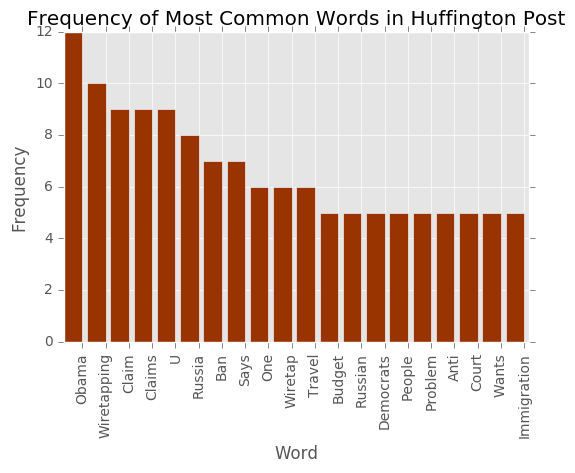

In [55]:
ind = np.arange(20)
width = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, df_huff.ix[:, 1].values, width, color = "#993300")
ax.set_ylabel('Frequency')
ax.set_xlabel('Word')
ax.set_xticks(ind+width)
ax.set_title("Frequency of Most Common Words in Huffington Post")
ax.set_xticklabels(df_huff[0], rotation = 90)
plt.show()

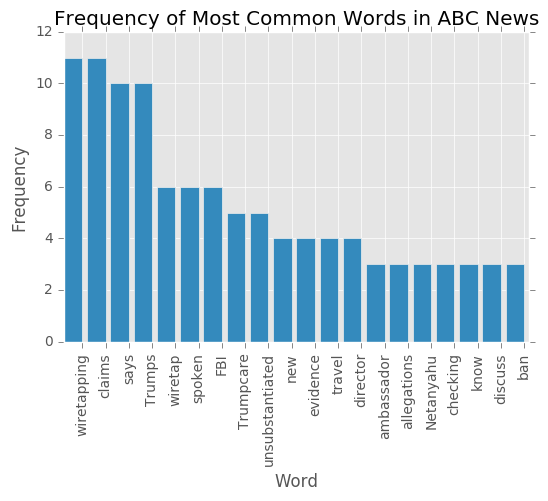

In [56]:
ind = np.arange(20)
width = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, df_abc.ix[:, 1].values, width)
ax.set_ylabel('Frequency')
ax.set_xlabel('Word')
ax.set_xticks(ind+width)
ax.set_title("Frequency of Most Common Words in ABC News")
ax.set_xticklabels(df_abc[0], rotation = 90)
plt.show()

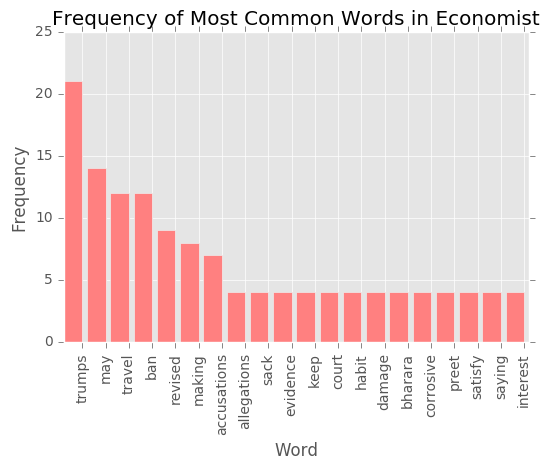

In [57]:
ind = np.arange(20)
width = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, df_econ.ix[:, 1].values, width, color = "#ff8080")
ax.set_ylabel('Frequency')
ax.set_xlabel('Word')
ax.set_xticks(ind+width)
ax.set_title("Frequency of Most Common Words in Economist")
ax.set_xticklabels(df_econ[0], rotation = 90)
plt.show()

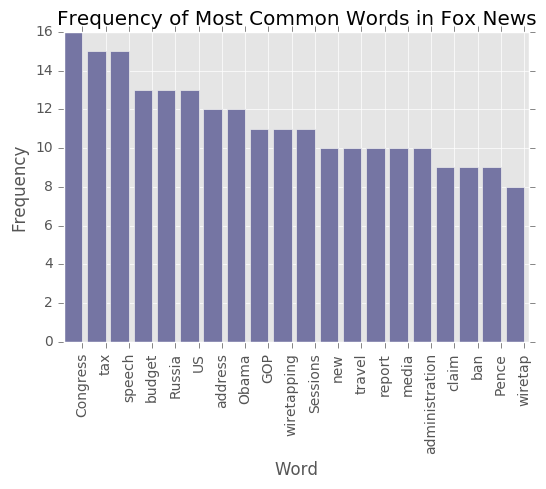

In [58]:
ind = np.arange(20)
width = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, df_fox.ix[:, 1].values, width, color = "#7575a3")
ax.set_ylabel('Frequency')
ax.set_xlabel('Word')
ax.set_xticks(ind+width)
ax.set_title("Frequency of Most Common Words in Fox News")
ax.set_xticklabels(df_fox[0], rotation = 90)
plt.show()

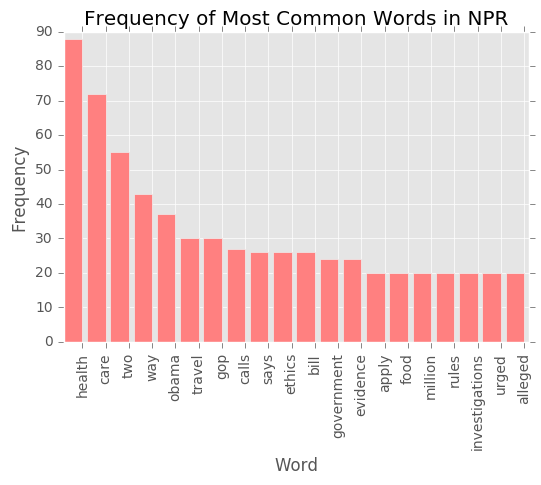

In [59]:
ind = np.arange(20)
width = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, df_npr.ix[:, 1].values, width, color = "#ff8080")
ax.set_ylabel('Frequency')
ax.set_xlabel('Word')
ax.set_xticks(ind+width)
ax.set_title("Frequency of Most Common Words in NPR")
ax.set_xticklabels(df_npr[0], rotation = 90)
plt.show()

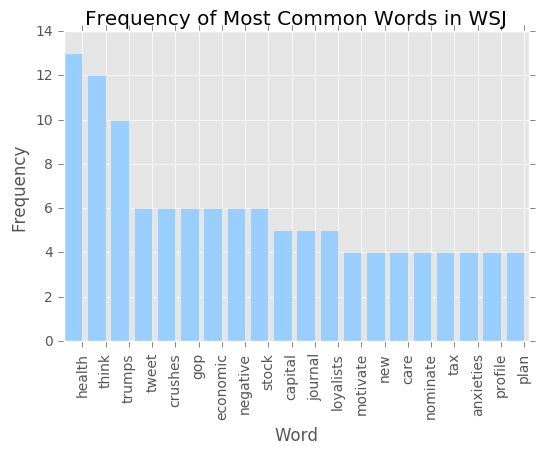

In [60]:
ind = np.arange(20)
width = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, df_wsj.ix[:, 1].values, width, color = "#99ceff")
ax.set_ylabel('Frequency')
ax.set_xlabel('Word')
ax.set_xticks(ind+width)
ax.set_title("Frequency of Most Common Words in WSJ")
ax.set_xticklabels(df_wsj[0], rotation = 90)
plt.show()

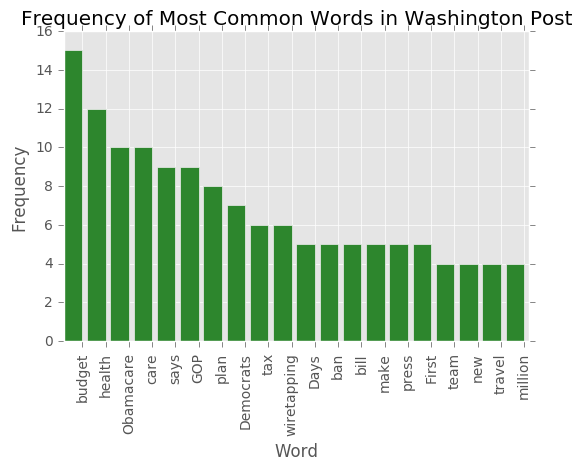

In [61]:
ind = np.arange(20)
width = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, df_wash.ix[:, 1].values, width, color = "#2d862d")
ax.set_ylabel('Frequency')
ax.set_xlabel('Word')
ax.set_xticks(ind+width)
ax.set_title("Frequency of Most Common Words in Washington Post")
ax.set_xticklabels(df_wash[0], rotation = 90)
plt.show()

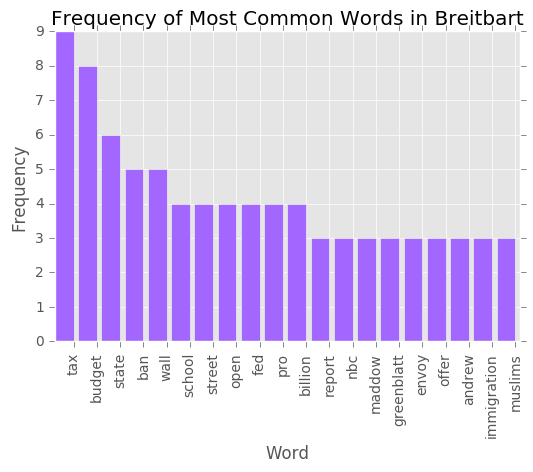

In [62]:
ind = np.arange(20)
width = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, df_bb.ix[:, 1].values, width, color = "#a366ff")
ax.set_ylabel('Frequency')
ax.set_xlabel('Word')
ax.set_xticks(ind+width)
ax.set_title("Frequency of Most Common Words in Breitbart")
ax.set_xticklabels(df_bb[0], rotation = 90)
plt.show()

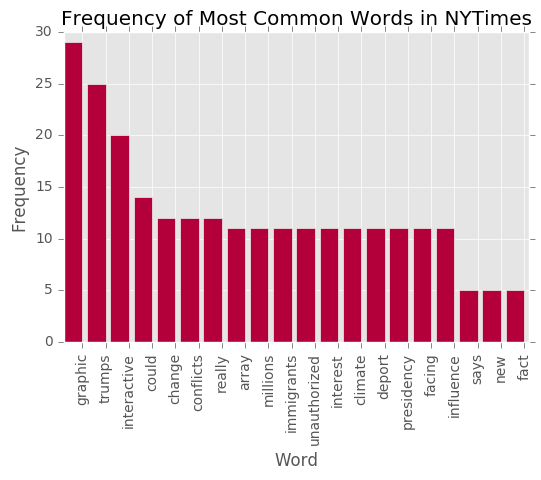

In [63]:
ind = np.arange(20)
width = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, df_nyt.ix[:, 1].values, width, color = "#b3003b")
ax.set_ylabel('Frequency')
ax.set_xlabel('Word')
ax.set_xticks(ind+width)
ax.set_title("Frequency of Most Common Words in NYTimes")
ax.set_xticklabels(df_nyt[0], rotation = 90)
plt.show()

<h3>Polarity and Subjectivity for Article Titles </h3>

We first obtain two lists (polarity and subjectivity for each website).

In [30]:
fox_polar, fox_subj = polar_subj(fox)
abc_polar, abc_subj = polar_subj(abc)
wsj_polar, wsj_subj = polar_subj(wsj)
npr_polar, npr_subj = polar_subj(npr)
nyt_polar, nyt_subj = polar_subj(nytimes)
wash_polar, wash_subj = polar_subj(washington)
huff_polar, huff_subj = polar_subj(huff)
breit_polar, breit_subj = polar_subj(breitbart)
econ_polar, econ_subj = polar_subj(economist)

Plot the article title polarity values for each news outlet 

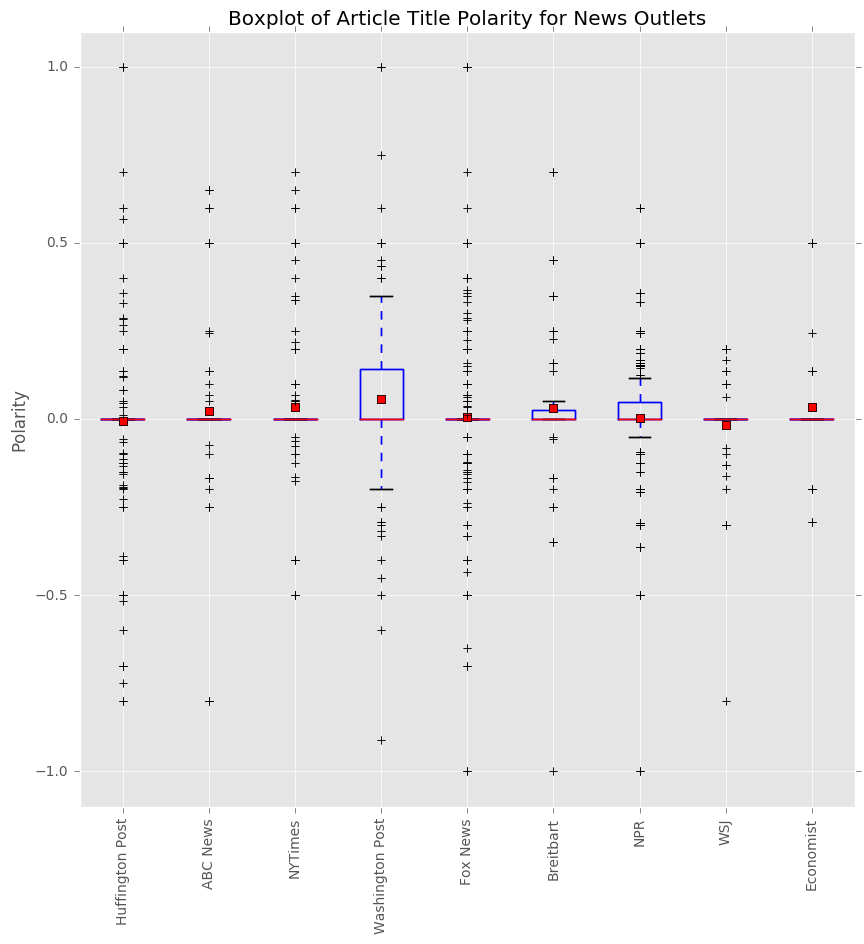

In [32]:
polar_to_plot = [huff_polar, abc_polar, nyt_polar, wash_polar, fox_polar, breit_polar, npr_polar, wsj_polar, econ_polar]
fig = plt.figure(1, figsize=(10, 10))
ax = fig.add_subplot(111)

bp = ax.boxplot(polar_to_plot, showmeans=True)
pylab.ylim([-1.1,1.1])
ax.set_title("Boxplot of Article Title Polarity for News Outlets")
ax.set_ylabel('Polarity')
ax.set_xticklabels( ('Huffington Post', 'ABC News', 'NYTimes', 'Washington Post', 'Fox News', 'Breitbart', 'NPR', 'WSJ', 'Economist') )
plt.xticks(rotation=90)
plt.show()

From this boxplot we see that most of the article title polarities are mainly slightly positive with the exception of Huffington Post and Wall Street Journal which seems to be a little more negative.

Plot the article title subjectivity values for each news outlet

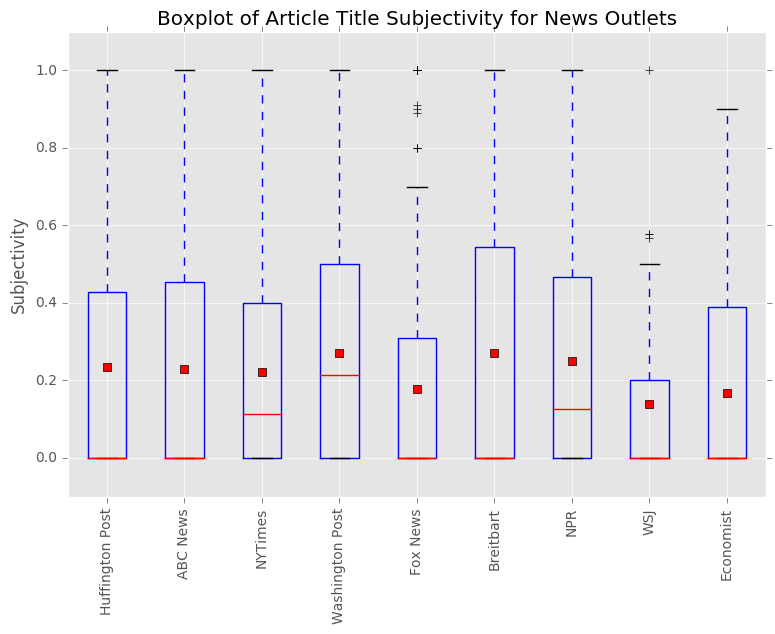

In [33]:
subj_to_plot = [huff_subj, abc_subj, nyt_subj, wash_subj, fox_subj, breit_subj, npr_subj, wsj_subj, econ_subj]
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)

bp = ax.boxplot(subj_to_plot, showmeans=True)
pylab.ylim([-0.1,1.1])
ax.set_title("Boxplot of Article Title Subjectivity for News Outlets")
ax.set_ylabel('Subjectivity')
ax.set_xticklabels( ('Huffington Post', 'ABC News', 'NYTimes', 'Washington Post', 'Fox News', 'Breitbart', 'NPR', 'WSJ', 'Economist') )
plt.xticks(rotation=90)
plt.show()

Overall, all of the article titles are subjective. Washington post seems to have the highest average subjectivity level whereas Wall Street Journal has the lowest average subjectivity level (and the lowest range in subjectivity percentage).

Plot the Polarity of Conservative, Liberal, and Other News Outlets

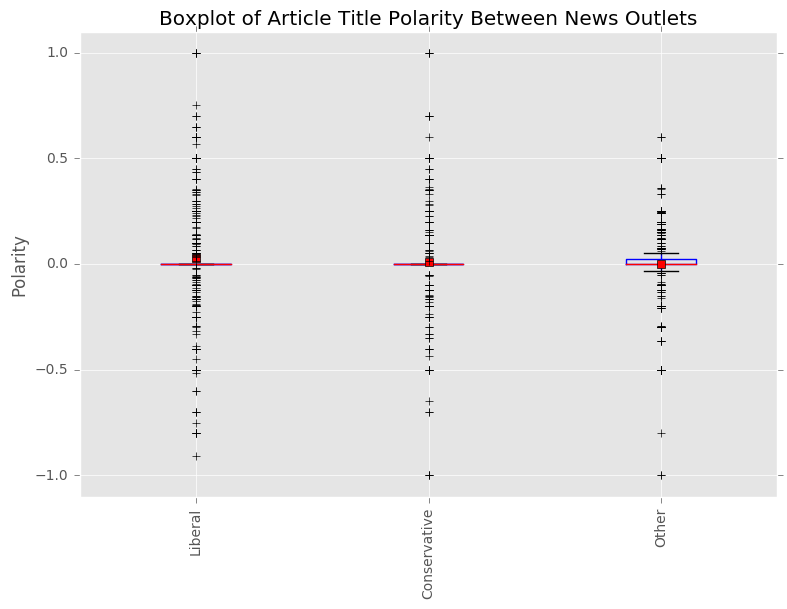

In [34]:
grouped_polar = [huff_polar+abc_polar+nyt_polar+wash_polar, fox_polar+breit_polar, npr_polar+wsj_polar+econ_polar]
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)

bp = ax.boxplot(grouped_polar, showmeans=True)
pylab.ylim([-1.1,1.1])
ax.set_title("Boxplot of Article Title Polarity Between News Outlets")
ax.set_ylabel('Polarity')
ax.set_xticklabels( ('Liberal', 'Conservative', 'Other') )
plt.xticks(rotation=90)
plt.show()

From this boxplot we see grouping the articles by type of newspaper leads to an inconclusive result. They all seem to have a polarity level of 0 (or close to 0) with a wide range of other polarities (from -1 to 1 with the exception of other).

Plot the Subjectivity of Conservative, Liberal, and Other News Outlets

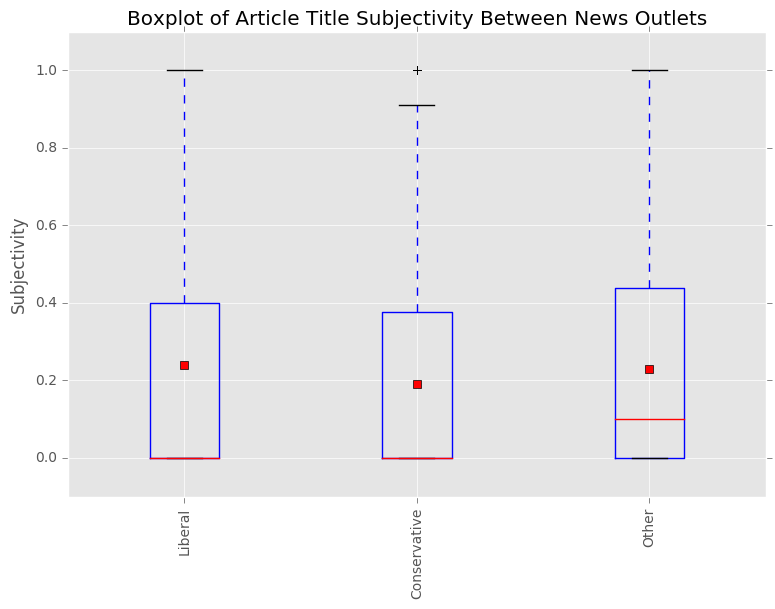

In [35]:
grouped_subj = [huff_subj+abc_subj+nyt_subj+wash_subj, fox_subj+breit_subj, npr_subj+wsj_subj+econ_subj]
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)

bp = ax.boxplot(grouped_subj, showmeans=True)
pylab.ylim([-0.1,1.1])
ax.set_title("Boxplot of Article Title Subjectivity Between News Outlets")
ax.set_ylabel('Subjectivity')
ax.set_xticklabels( ('Liberal', 'Conservative', 'Other') )
plt.xticks(rotation=90)
plt.show()

The results here are slightly more clear. The liberal and other newspapers have a higher subjectivity level than conservative newspaper. But all three are subjective.

<h3>Comparing all titles from News Sources</h3>

Make a dataframe of all of the titles

In [38]:
organize = pd.DataFrame(columns =['title','type'])
liberal = huff+nytimes+abc+washington
conservative = breitbart+fox
other = npr+economist+wsj
total_titles = liberal+conservative+other

Create a dataframe of all of the titles and the type of newspaper they came from.

In [39]:
for i in range(len(total_titles)):
    if i <= len(liberal):
        organize.loc[i] = [total_titles[i], "Liberal"]
    if (i > len(liberal) and i <= len(liberal+conservative)):
        organize.loc[i] = [total_titles[i], "Conservative"]
    if i > len(liberal+conservative):
        organize.loc[i] = [total_titles[i], "Other"]

In [41]:
tfidf = TfidfVectorizer().fit_transform(total_titles)
pairwise_similarity = tfidf * tfidf.T

Get all tuples of titles with greatest similarity

In [42]:
x = []
y = []
for row in range(pairwise_similarity.shape[0]):
    for col in range(pairwise_similarity.shape[1]):
        if pairwise_similarity[row,col] >= 0.75:
            if round(pairwise_similarity[row,col],4) != 1:
                x.append(row)
                y.append(col)
similar_titles = zip(x,y)

Get all unique tuples

In [43]:
unique = []
for item in similar_titles:
    if not (item in unique or tuple([item[1], item[0]]) in unique):
        unique.append(item)

Find the titles that are associated with tuples

In [44]:
sim_titles = []
for t in unique:
    sim_titles.append(zip(organize.loc[t[0]], organize.loc[t[1]]))
pd.set_option('display.width', 1000)
similar_title = pd.DataFrame(sim_titles, columns =['Similar Titles','Type'])
similar_title = pd.concat([similar_title.iloc[0:5],similar_title.iloc[8:14],similar_title.iloc[16:20],similar_title.iloc[24:25]])
similar_title = similar_title.set_index([range(len(similar_title))])

Dataframe of pairwise title comparisons

In [45]:
pd.options.display.max_colwidth = 300
similar_title

,Similar Titles,Type
0,"(Here Are The Many Ways Trump Scares The Crap Out Of Democrats, Here Are The Many Ways Donald Trump Scares The Crap Out Of Democrats)","(Liberal, Liberal)"
1,"(Obama EPA Head Savages Trump's Environmental Policies, Obama EPA Head Savages Donald Trump's Environmental Policies)","(Liberal, Liberal)"
2,"(U.S. Politicians Want To Quiz British Spy Who Wrote Russian Dossier On Trump, U.S. Politicians Seek To Quiz British Spy Who Wrote Russian Dossier On Donald Trump)","(Liberal, Liberal)"
3,"(McCain Calls On Trump To Retract Obama Wiretap Claim Or Prove It, McCain to Trump: Retract wiretapping claim or prove it)","(Liberal, Liberal)"
4,"(Tracing where Trump gets some of his news ,, Tracing where President Trump gets some of his news ,)","(Liberal, Liberal)"
5,"(WH: Trump meeting with Russian ambassador absurd, WH calls reported Trump meeting with Russian ambassador absurd)","(Liberal, Liberal)"
6,"(What we know about Trumps unsubstantiated wiretapping..., What we know about Trumps unsubstantiated wiretapping allegations)","(Liberal, Liberal)"
7,"(Trump, Netanyahu speak by phone, discuss Irans malevolent..., Trump, Netanyahu speak by phone, discuss Irans malevolent behavior)","(Liberal, Liberal)"
8,"(White House calls reported Trump meeting with Russian ambassador absurd, WH calls reported Trump meeting with Russian ambassador absurd)","(Liberal, Liberal)"
9,"(Flynns lawyer told Trump team about lobbying during..., Flynns lawyer told Trump team about lobbying during transition)","(Liberal, Liberal)"


Comparing the titles for liberal, conservative, and other news sources for the most similar titles, there are the most similarites within groups rather than between groups. Liberal news sources share the most similar titles with other liberal news sources. Conservative news sources also have the most similar titles to other conservative news sources. This may mean that the type of news that liberal news sources cover are very different from those of conservative news sources. Conservative news sources never share a similar article title with liberal news sources. As shown in the table, conservative news sources and liberal news also share similar titles to "other" news sources. This implies that "other" news sources cover some liberal and some conservative news.

<h3>Media's Ideology and Its Perception of Trump</h3>

In [46]:
superfindf = pd.read_csv('analysis.csv')

In [53]:
x = range(-10,11)
y = [0]*21
y2 = range(-1,2)
x2 = [0]*3

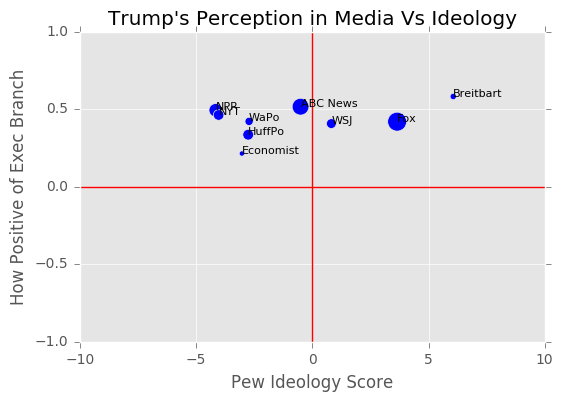

In [60]:
fig, ax = plt.subplots()
ax.plot(x,y,c = 'red')
ax.plot(x2,y2,c = 'red')
ax.scatter(x = superfindf['pew score'], y = superfindf['pose'],s = superfindf['betsum']*85);
for i in range(9):
    ax.annotate(superfindf['news'][i],(superfindf['pew score'][i], superfindf['pose'][i]), size = 8)
ax.set_xlabel('Pew Ideology Score')
ax.set_ylabel('How Positive of Exec Branch')
ax.set_title('Trump\'s Perception in Media Vs Ideology')
plt.xlim(-10,10)
plt.ylim(-1,1)
plt.show()

In [50]:
superfindf['difference'] = superfindf['pose'] - superfindf['norms']

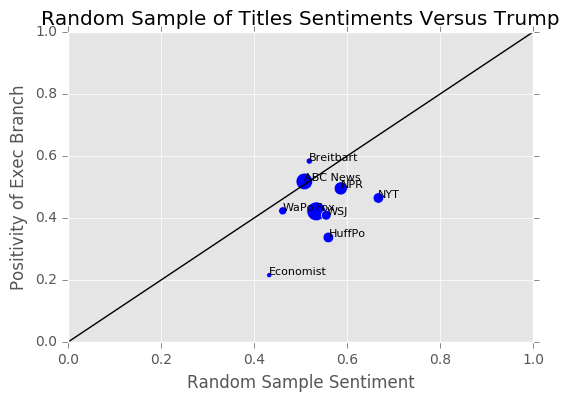

In [56]:
xline = [0,1]
yline = xline
fig, ax = plt.subplots()
ax.scatter(x = superfindf['norms'], y = superfindf['pose'],s = superfindf['betsum']*85);
for i in range(9):
    ax.annotate(superfindf['news'][i],(superfindf['norms'][i], superfindf['pose'][i]), size = 8)
ax.set_xlabel('Random Sample Sentiment')
ax.set_ylabel('Positivity of Exec Branch')
ax.set_title('Random Sample of Titles Sentiments Versus Trump')
ax.plot(xline,c = 'black')


plt.xlim(0,1);
plt.ylim(0,1);
plt.show()

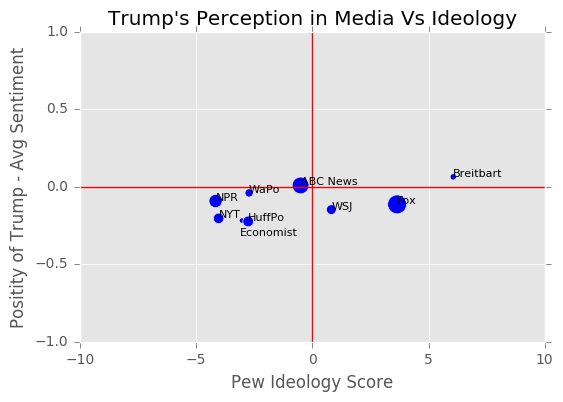

In [63]:
fig, ax = plt.subplots()
ax.plot(x,y,c = 'red')
ax.plot(x2,y2,c = 'red')
ax.scatter(x = superfindf['pew score'], y = superfindf['difference'],s = superfindf['betsum']*85);
for i in range(9):
    if(superfindf['news'][i] != 'Economist'):
        ax.annotate(superfindf['news'][i],(superfindf['pew score'][i], superfindf['difference'][i]), size = 8)
    else:
        ax.annotate(superfindf['news'][i],(superfindf['pew score'][i] -.1, superfindf['difference'][i] - .1), size = 8)
ax.set_xlabel('Pew Ideology Score')
ax.set_ylabel('Positity of Trump - Avg Sentiment')
ax.set_title('Trump\'s Perception in Media Vs Ideology')
plt.xlim(-10,10);
plt.ylim(-1,1);
plt.show()